In [141]:
import pandas as pd
import json
from typing import List
import requests
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import numpy as np

In [142]:
class IpToLonAndLat:
    def __init__(self, ip, lon, lat):
        self.ip = ip
        self.lon = lon
        self.lat = lat

    def __eq__(self, other):
        # Define equality based on the attributes of the object
        if isinstance(other, IpToLonAndLat):
            return (self.ip, self.lon, self.lat) == (other.ip, other.lon, other.lat)
        return False

    def __hash__(self):
        # Define a hash based on the attributes of the object
        return hash((self.ip, self.lon, self.lat))

    def __repr__(self):
        return f"IpToLonAndLat(ip='{self.ip}', lon={self.lon}, lat={self.lat})"

    def to_dict(self):
        """Converts the IpToLonAndLat instance to a dictionary."""
        return {
            'ip': self.ip,
            'lon': self.lon,
            'lat': self.lat
        }

In [143]:
def parse_speed_to_bps(speed_str):
    # Normalize case and remove spaces
    speed_str = speed_str.strip().upper()

    # Extract numeric value and unit using regex
    match = re.match(r"([\d.]+)([A-Za-z]+)BPS", speed_str)
    if not match:
        raise ValueError("Invalid speed format. Must be in the format like '1Gbps', '100Mbps'.")

    value, unit = float(match.group(1)), match.group(2)

    # Convert based on unit prefix
    if unit == "G":
        return int(value * 1_000_000_000)  # Gbps to bps
    elif unit == "M":
        return int(value * 1_000_000)  # Mbps to bps
    elif unit == "K":
        return int(value * 1_000)  # Kbps to bps
    elif unit == "B":  # Edge case: just "bps"
        return int(value)
    else:
        raise ValueError(f"Unsupported unit '{unit}' in speed string.")


def read_in_ip_map(ip_path) -> List[List[IpToLonAndLat]]:
    list_of_ip_objects = []
    with open(ip_path, 'r') as f:
        for line in f:
            try:
                pmeter_data = json.loads(line.strip())
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                continue

            # Convert each IP entry to an IpToLonAndLat object
            ip_objects = [
                IpToLonAndLat(ip=key, lon=value['lon'], lat=value['lat'])
                for key, value in pmeter_data.items()
                if key != "time"  # Exclude the "time" key
            ]
            list_of_ip_objects.append(ip_objects)
    return list_of_ip_objects


def read_in_node_file(node_path):
    with open(node_path, 'r') as f:
        node_list = json.load(f)  # Parse the entire JSON array at once
    return node_list


def read_in_job_file(job_file_path):
    with open(job_file_path, 'r') as f:
        job_list = json.load(f)
    return job_list


def fetch_forecast_for_ip(ipCoordinate: IpToLonAndLat):
    """
    Helper method to fetch forecast data for a single IP coordinate.
    """
    headers = {"auth-token": os.getenv("ELECTRICITY_MAPS_FORECAST_TOKEN")}
    param = {"lon": ipCoordinate.lon, "lat": ipCoordinate.lat}
    resp = requests.get("https://api.electricitymap.org/v3/carbon-intensity/forecast", params=param,
                        headers=headers)
    data = resp.json()
    forecast_list = data.get('forecast', [])
    results = []
    for idx, entry in enumerate(forecast_list):
        results.append({
            "ip": ipCoordinate.ip,
            "timestamp": entry['datetime'],
            "ci": entry['carbonIntensity'],
            "forecast_idx": idx
        })
    return results


In [144]:
ip_list = read_in_ip_map('config/trace_route_with_coordinates.json')
node_list = read_in_node_file('config/nodes_config.json')
job_list = read_in_job_file('config/jobs.json')
print(node_list)
print(job_list)

[{'name': 'jgoldverg@gmail.com-ccuc', 'total_ram': 128, 'NIC_SPEED': '10Gbps', 'CPU': 64, 'power': {'min': 8.5, 'max': 31}}]
[{'bytes': '1000000000', 'files_count': 1, 'id': 1, 'deadline': ''}, {'bytes': '100000000000', 'files_count': 100, 'id': 3, 'deadline': ''}, {'bytes': '10000000000000', 'files_count': 100, 'id': 2, 'deadline': ''}]


In [145]:
one_trace_route = ip_list[0]
forecasts = []
for ipLonLat in one_trace_route:
    forecasts.append(fetch_forecast_for_ip(ipLonLat))
print(forecasts)

[[{'ip': '192.5.86.1', 'timestamp': '2025-02-03T17:00:00.000Z', 'ci': 388, 'forecast_idx': 0}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T18:00:00.000Z', 'ci': 384, 'forecast_idx': 1}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T19:00:00.000Z', 'ci': 383, 'forecast_idx': 2}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T20:00:00.000Z', 'ci': 391, 'forecast_idx': 3}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T21:00:00.000Z', 'ci': 402, 'forecast_idx': 4}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T22:00:00.000Z', 'ci': 408, 'forecast_idx': 5}, {'ip': '192.5.86.1', 'timestamp': '2025-02-03T23:00:00.000Z', 'ci': 402, 'forecast_idx': 6}, {'ip': '192.5.86.1', 'timestamp': '2025-02-04T00:00:00.000Z', 'ci': 403, 'forecast_idx': 7}, {'ip': '192.5.86.1', 'timestamp': '2025-02-04T01:00:00.000Z', 'ci': 403, 'forecast_idx': 8}, {'ip': '192.5.86.1', 'timestamp': '2025-02-04T02:00:00.000Z', 'ci': 406, 'forecast_idx': 9}, {'ip': '192.5.86.1', 'timestamp': '2025-02-04T03:00:00.000Z', 'ci': 

In [146]:
flat_data = [item for sublist in forecasts for item in sublist]
forecast_df = pd.DataFrame(flat_data)
forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])
print(forecast_df)

                  ip                 timestamp   ci  forecast_idx
0         192.5.86.1 2025-02-03 17:00:00+00:00  388             0
1         192.5.86.1 2025-02-03 18:00:00+00:00  384             1
2         192.5.86.1 2025-02-03 19:00:00+00:00  383             2
3         192.5.86.1 2025-02-03 20:00:00+00:00  391             3
4         192.5.86.1 2025-02-03 21:00:00+00:00  402             4
..               ...                       ...  ...           ...
345  129.114.108.207 2025-02-04 13:00:00+00:00  400            20
346  129.114.108.207 2025-02-04 14:00:00+00:00  391            21
347  129.114.108.207 2025-02-04 15:00:00+00:00  364            22
348  129.114.108.207 2025-02-04 16:00:00+00:00  314            23
349  129.114.108.207 2025-02-04 17:00:00+00:00  297            24

[350 rows x 4 columns]


In [147]:
associations_df = pd.read_csv('data/associations_df.csv')
print(associations_df.head())

   Unnamed: 0                      node  job_id  forecast_id  transfer_time  \
0           0  jgoldverg@gmail.com-ccuc       1            0            0.8   
1           1  jgoldverg@gmail.com-ccuc       3            0           80.0   
2           2  jgoldverg@gmail.com-ccuc       2            0         8000.0   
3           3  jgoldverg@gmail.com-ccuc       1            1            0.8   
4           4  jgoldverg@gmail.com-ccuc       3            1           80.0   

    throughput  max_energy  min_energy  avg_ci  carbon_emissions  
0  10000000000        24.8         6.8   447.0          0.003079  
1  10000000000      2480.0       680.0   447.0          0.307933  
2  10000000000    248000.0     68000.0   447.0         30.793333  
3  10000000000        24.8         6.8   432.0          0.002976  
4  10000000000      2480.0       680.0   432.0          0.297600  


In [148]:
# Extract unique nodes and forecast_ids
columns = associations_df['node'].unique()  # Unique node names (columns)
rows = associations_df['forecast_id'].unique()  # Unique forecast IDs (rows)
scheduled_jobs = {}

# Initialize schedule matrix with NaN values
matrix_schedule = pd.DataFrame(np.nan, index=rows, columns=columns)

for job in job_list:
    job_df = associations_df[associations_df['job_id'] == job['id']]
    sorted_job_df = job_df.sort_values(by='avg_ci', ascending=True)
    lowest_avg_ci_forecasts = sorted_job_df.head(len(job_list))

    for index, row in lowest_avg_ci_forecasts.iterrows():
        forecast_idx = row['forecast_id']
        node_idx = row['node']

        if pd.isna(matrix_schedule.loc[forecast_idx, node_idx]):
            matrix_schedule.loc[forecast_idx, node_idx] = job['id']  # Assign job ID
            break

print(matrix_schedule)

    jgoldverg@gmail.com-ccuc
0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                        1.0
5                        3.0
6                        NaN
7                        NaN
8                        NaN
9                        NaN
10                       NaN
11                       NaN
12                       NaN
13                       NaN
14                       NaN
15                       NaN
16                       NaN
17                       NaN
18                       NaN
19                       NaN
20                       NaN
21                       NaN
22                       NaN
23                       NaN
24                       2.0


In [149]:
# Total emissions of proposed schedule
custom_total_carbon_emissions = 0

for forecast_id in matrix_schedule.index:
    for node in matrix_schedule.columns:
        job_id = matrix_schedule.loc[forecast_id, node]
        if not pd.isna(job_id):  # Check if a job is assigned
            job_ci = associations_df[(associations_df['job_id'] == job_id) &
                                     (associations_df['forecast_id'] == forecast_id) &
                                     (associations_df['node'] == node)]['avg_ci']
            if not job_ci.empty:
                custom_total_carbon_emissions += job_ci.values[0]  # Add carbon emissions
            else:
                print("job Ci is empty")

print(f"Total Carbon Intensity for created schedule: {custom_total_carbon_emissions}")



Total Carbon Intensity for created schedule: 1234.7142857142858


In [150]:
import random

# Copy the matrix and randomly assign jobs
random_schedule = pd.DataFrame(np.nan, index=associations_df['forecast_id'].unique(),
                               columns=associations_df['node'].unique())

# Keep track of assigned forecast-node pairs
assigned_pairs = set()

# Randomly assign jobs to forecast-node pairs
for job in job_list:
    # Randomly choose a forecast-id and node, ensuring no duplicate assignments
    while True:
        forecast_idx = random.choice(associations_df['forecast_id'].unique())
        node_idx = random.choice(associations_df['node'].unique())

        # Check if the forecast-node pair has already been assigned a job
        if (forecast_idx, node_idx) not in assigned_pairs:
            random_schedule.loc[forecast_idx, node_idx] = job['id']
            assigned_pairs.add((forecast_idx, node_idx))  # Mark the pair as assigned
            break  # Break once the job is successfully assigned

# Print the random schedule
print(random_schedule)

# Compute carbon emissions and balance score for the random schedule
random_total_carbon_emissions = 0
for forecast_id in random_schedule.index:
    for node in random_schedule.columns:
        job_id = random_schedule.loc[forecast_id, node]
        if not pd.isna(job_id):
            job_ci = associations_df[(associations_df['job_id'] == job_id) &
                                     (associations_df['forecast_id'] == forecast_id) &
                                     (associations_df['node'] == node)]['avg_ci']
            if not job_ci.empty:
                random_total_carbon_emissions += job_ci.values[0]
            else:
                print("Job CI is empty")

# Compute load balancing score
random_load_balance_score = random_schedule.count().std()

print(f"Random Schedule - Carbon Intensity: {random_total_carbon_emissions}")
print(f"Random Schedule - Load Balance Score: {random_load_balance_score}")


    jgoldverg@gmail.com-ccuc
0                        NaN
1                        NaN
2                        NaN
3                        2.0
4                        NaN
5                        NaN
6                        NaN
7                        NaN
8                        NaN
9                        NaN
10                       NaN
11                       NaN
12                       NaN
13                       NaN
14                       NaN
15                       3.0
16                       NaN
17                       1.0
18                       NaN
19                       NaN
20                       NaN
21                       NaN
22                       NaN
23                       NaN
24                       NaN
Random Schedule - Carbon Intensity: 1330.0714285714284
Random Schedule - Load Balance Score: nan


In [151]:
worst_case_schedule = pd.DataFrame(np.nan, index=rows, columns=columns)

for job in job_list:
    job_df = associations_df[associations_df['job_id'] == job['id']]
    sorted_job_df = job_df.sort_values(by='avg_ci', ascending=False)
    highest_avg_ci_forecasts = sorted_job_df.head(len(job_list))
    for index, row in highest_avg_ci_forecasts.iterrows():
        forecast_idx = row['forecast_id']
        node_idx = row['node']
        if pd.isna(worst_case_schedule.loc[forecast_idx, node_idx]):
            worst_case_schedule.loc[forecast_idx, node_idx] = job['id']  # Assign job ID
            break

print(worst_case_schedule)
# Total emissions of proposed schedule
worst_case_carbon_emissions = 0

for forecast_id in worst_case_schedule.index:
    for node in worst_case_schedule.columns:
        job_id = worst_case_schedule.loc[forecast_id, node]
        if not pd.isna(job_id):  # Check if a job is assigned
            job_ci = associations_df[(associations_df['job_id'] == job_id) &
                                     (associations_df['forecast_id'] == forecast_id) &
                                     (associations_df['node'] == node)]['avg_ci']
            if not job_ci.empty:
                worst_case_carbon_emissions += job_ci.values[0]  # Add carbon emissions
            else:
                print("job Ci is empty")

print(f"Total Carbon Intensity for Worst Case schedule: {worst_case_carbon_emissions}")



    jgoldverg@gmail.com-ccuc
0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                        NaN
5                        NaN
6                        NaN
7                        NaN
8                        NaN
9                        NaN
10                       NaN
11                       1.0
12                       3.0
13                       2.0
14                       NaN
15                       NaN
16                       NaN
17                       NaN
18                       NaN
19                       NaN
20                       NaN
21                       NaN
22                       NaN
23                       NaN
24                       NaN
Total Carbon Intensity for Worst Case schedule: 1419.9285714285713


In [155]:
import random

# Copy the matrix and randomly assign jobs
basic_schedule = pd.DataFrame(np.nan, index=associations_df['forecast_id'].unique(),
                              columns=associations_df['node'].unique())

# Keep track of assigned forecast-node pairs
assigned_pairs = set()

# Randomly assign jobs to forecast-node pairs
for job in job_list:
    node_idx = 'jgoldverg@gmail.com-ccuc'
    for forecast_idx in associations_df['forecast_id'].unique():
        if (forecast_idx, node_idx) not in assigned_pairs:
            basic_schedule.loc[forecast_idx, node_idx] = job['id']
            assigned_pairs.add((forecast_idx, node_idx))
            break

# Print the random schedule
print(basic_schedule)

# Compute carbon emissions and balance score for the random schedule
basic_carbon_emissions = 0
for forecast_id in basic_schedule.index:
    for node in basic_schedule.columns:
        job_id = basic_schedule.loc[forecast_id, node]
        if not pd.isna(job_id):
            job_ci = associations_df[(associations_df['job_id'] == job_id) &
                                     (associations_df['forecast_id'] == forecast_id) &
                                     (associations_df['node'] == node)]['avg_ci']
            if not job_ci.empty:
                basic_carbon_emissions += job_ci.values[0]
            else:
                print("Job CI is empty")

print(f"Basic Schedule - Carbon Intensity: {basic_carbon_emissions}")


    jgoldverg@gmail.com-ccuc
0                        1.0
1                        3.0
2                        2.0
3                        NaN
4                        NaN
5                        NaN
6                        NaN
7                        NaN
8                        NaN
9                        NaN
10                       NaN
11                       NaN
12                       NaN
13                       NaN
14                       NaN
15                       NaN
16                       NaN
17                       NaN
18                       NaN
19                       NaN
20                       NaN
21                       NaN
22                       NaN
23                       NaN
24                       NaN
Basic Schedule - Carbon Intensity: 1295.2142857142858


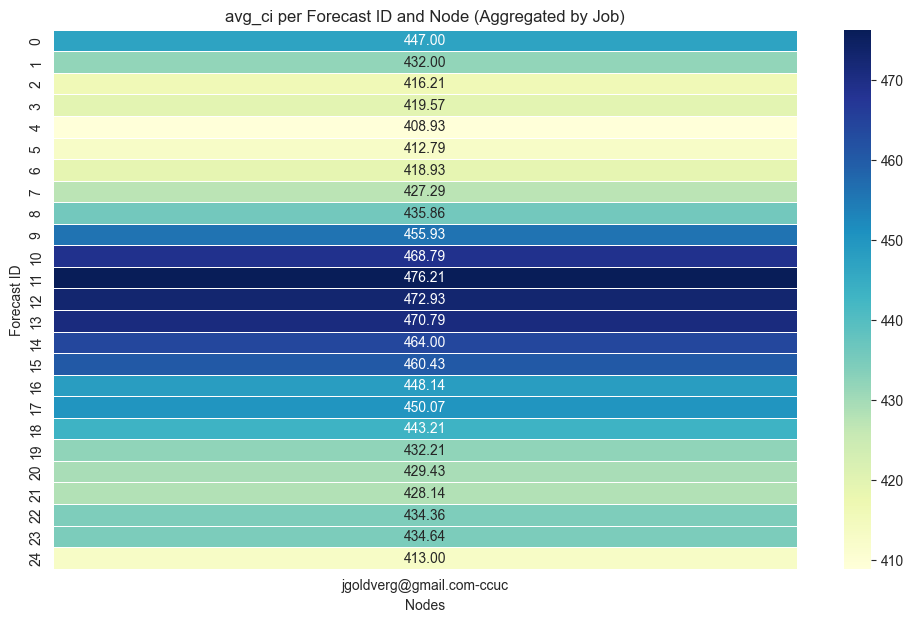

In [152]:
# Group by forecast_id, node, and job_id, and calculate the mean of avg_ci
aggregated_df = associations_df.groupby(['forecast_id', 'node', 'job_id'], as_index=False)['avg_ci'].mean()

# Pivot the data to have forecast_id as rows, node as columns, and avg_ci as values
pivot_df = aggregated_df.pivot_table(index='forecast_id', columns='node', values='avg_ci', aggfunc='mean')

plt.figure(figsize=(12, 7))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, cbar=True)

plt.title("avg_ci per Forecast ID and Node (Aggregated by Job)")
plt.xlabel("Nodes")
plt.ylabel("Forecast ID")
plt.show()


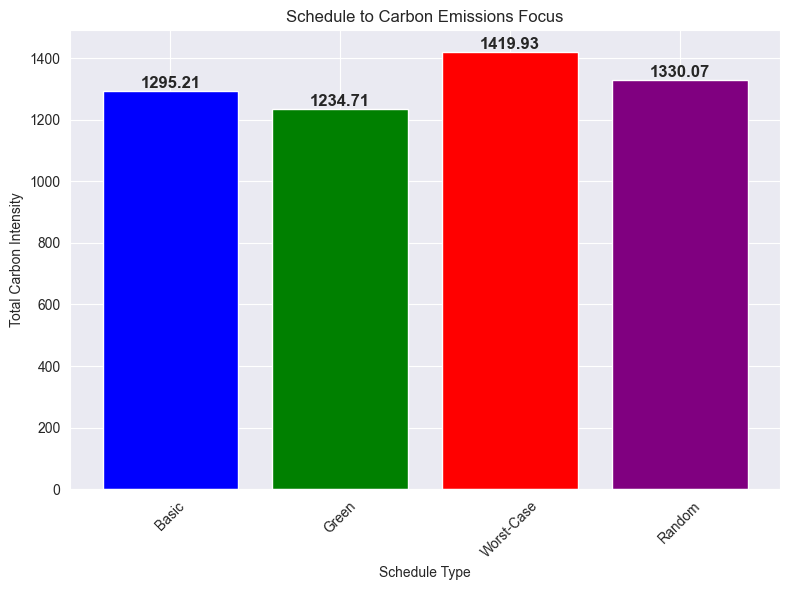

Shifting in a 24 hour forecast Comparison of Approaches:
Minimize Carbon Intensity Schedule - Carbon Intensity: 1234.7142857142858
Worst-Case Schedule - Carbon Intensity: 1419.9285714285713
Random Schedule - Carbon Intensity: 1330.0714285714284
Improvement over Worst-Case Schedule: 13.04%
Improvement over Random Schedule: 7.17%
Improvement over Basic Schedule: 4.67%


In [164]:
# Define the comparison approaches
approaches = ['Basic', 'Green', 'Worst-Case', 'Random']
carbon_emissions = [basic_carbon_emissions, custom_total_carbon_emissions, worst_case_carbon_emissions, random_total_carbon_emissions]

# Create a figure with a single bar plot for Carbon Emissions
fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot for Carbon Emissions
bars = ax.bar(approaches, carbon_emissions, color=['blue', 'green','red', 'purple'])

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title("Schedule to Carbon Emissions Focus")
ax.set_ylabel("Total Carbon Intensity")
ax.set_xlabel("Schedule Type")
ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print the results for textual comparison
print("Shifting in a 24 hour forecast Comparison of Approaches:")
print(f"Minimize Carbon Intensity Schedule - Carbon Intensity: {custom_total_carbon_emissions}")
print(f"Worst-Case Schedule - Carbon Intensity: {worst_case_carbon_emissions}")
print(f"Random Schedule - Carbon Intensity: {random_total_carbon_emissions}")
improvement_worst = ((worst_case_carbon_emissions - custom_total_carbon_emissions) / worst_case_carbon_emissions) * 100
improvement_random = ((random_total_carbon_emissions - custom_total_carbon_emissions) / random_total_carbon_emissions) * 100
improvement_basic = ((basic_carbon_emissions - custom_total_carbon_emissions) / basic_carbon_emissions) * 100

print(f"Improvement over Worst-Case Schedule: {improvement_worst:.2f}%")
print(f"Improvement over Random Schedule: {improvement_random:.2f}%")
print(f"Improvement over Basic Schedule: {improvement_basic:.2f}%")


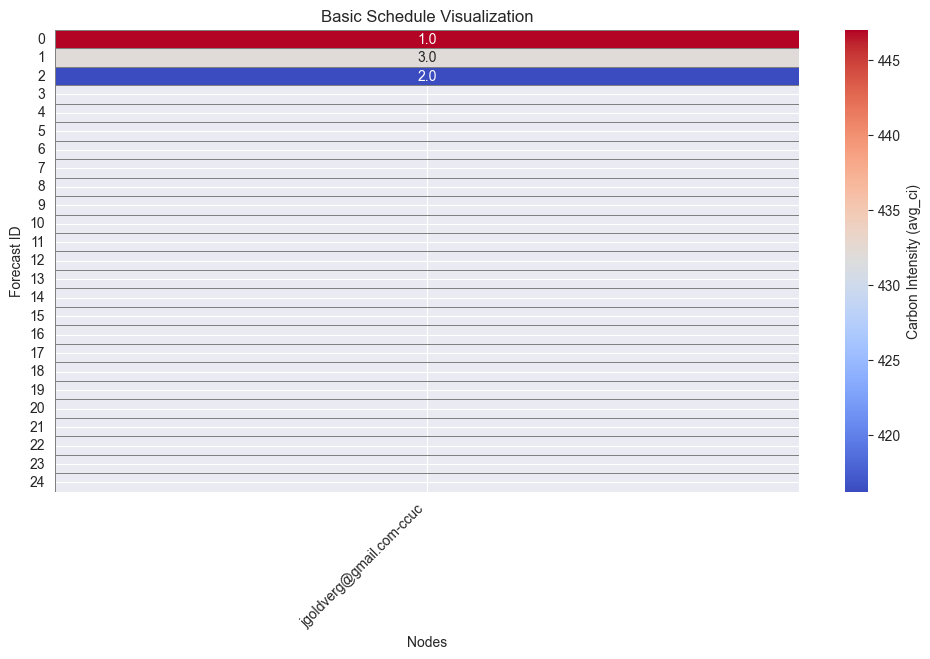

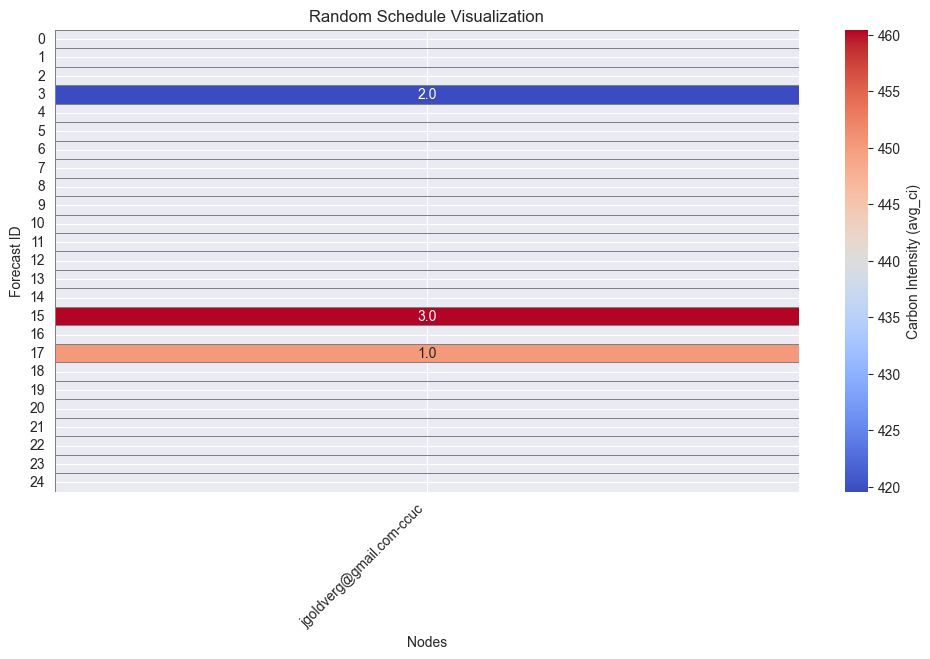

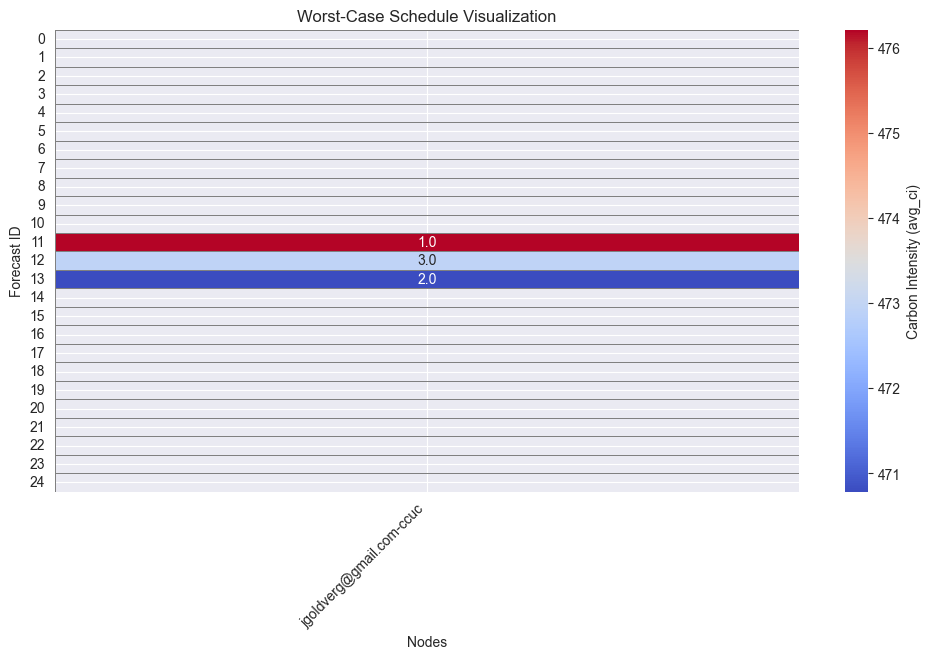

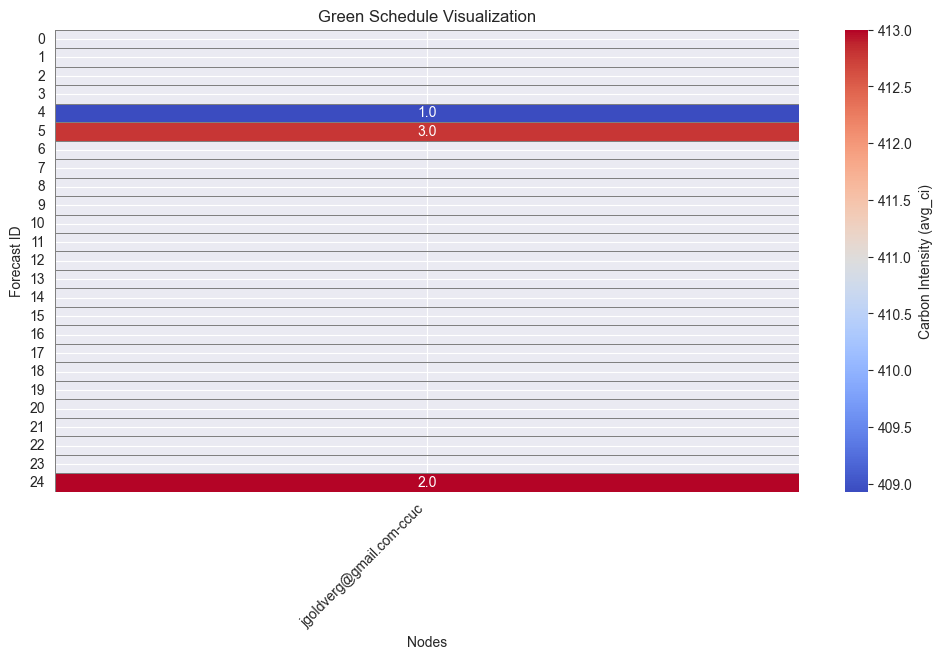

In [163]:
def visualize_schedule(schedule_df, associations_df, title="Schedule Visualization"):
    """
    Visualizes the schedule matrix with color representing avg_ci and text showing job assignments.

    :param schedule_df: Pandas DataFrame representing the schedule (forecast_id as index, nodes as columns)
    :param associations_df: DataFrame containing job_id, forecast_id, node, and avg_ci data
    :param title: Title of the plot
    """
    # Create a matrix to store avg_ci values
    heatmap_data = np.full(schedule_df.shape, np.nan)  # Initialize with NaN

    # Fill the heatmap matrix with avg_ci values based on job assignments
    for i, forecast_id in enumerate(schedule_df.index):
        for j, node in enumerate(schedule_df.columns):
            job_id = schedule_df.loc[forecast_id, node]
            if not pd.isna(job_id):
                job_ci = associations_df[(associations_df['job_id'] == job_id) &
                                         (associations_df['forecast_id'] == forecast_id) &
                                         (associations_df['node'] == node)]['avg_ci']
                if not job_ci.empty:
                    heatmap_data[i, j] = job_ci.values[0]  # Assign avg_ci value

    # Create the figure and axis
    plt.figure(figsize=(12, 6))

    # Create a heatmap with avg_ci values
    ax = sns.heatmap(heatmap_data, annot=schedule_df.values, fmt='', cmap="coolwarm",
                      linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Carbon Intensity (avg_ci)'})

    # Set labels and title
    ax.set_xticklabels(schedule_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(schedule_df.index, rotation=0)
    ax.set_title(title)
    ax.set_xlabel("Nodes")
    ax.set_ylabel("Forecast ID")

    # Show the plot
    plt.show()

# Example usage:
visualize_schedule(basic_schedule, associations_df, title="Basic Schedule Visualization")
visualize_schedule(random_schedule, associations_df, title="Random Schedule Visualization")
visualize_schedule(worst_case_schedule, associations_df, title="Worst-Case Schedule Visualization")
visualize_schedule(matrix_schedule, associations_df, title="Green Schedule Visualization")